# Insights of a hotel business through data science analysis

## Introduction

This project intends to analyse data from an existing hotel using techniques from data science to get deeper insight of a hotel's business performance during the last six years.
The data which was made available by a hotel which is located in the western part of germany at the edge of a large industrial area with good transportation connections to close cities and the industrial area. Due to several cultural spots and events of interest in and around the location close to the hotel, the attractivness for leisure tourism increases. Thus, leisure tourism is as much important as business tourism. However, the name of the hotel will not be disclosed due to privacy reasons to not connect the analysis results with the hotel for public.
The available data comprises information about the number of guests, local and foreign number of occupied rooms and the revenue of the hotel for a time period from 2013 (Januaray) to 2018 (December). To discover this data it is read and cleaned in the beginning. Further, the data is inspected with techniques of descriptive statistics and, in the end, the development over time is demonstrated with a time series analysis. The analysis will follow the goal of the approval of hypotheses created by inspecting the data.

### Hypotheses

1. The hotel is more occupied by local than foreign guests.
2. Seasonality has a small impact on the occupation due to the business tourism and several cultural events throughout the year close to the area were the hotel is situated.
3. The revenue of the hotel depends on the occupation of the hotel. An increase of occupation will show an increase of the revenue.

## Data - Extraction, Inspection, Description

### Load Packages

To run this jupyter notebook and the analysis the following packages are needed.
- pandas, numpy
    - arrange and manage data
- datetime
    - type casting
- matplotlib, seaborn
    - plot graphs
- statsmodels
    - time series analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
import seaborn as sns

### Data Storage

The data is stored in several .csv files. It is divided into general data and foreign data. Each csvfile containing general data is named by the month and contains data for each year between 2013 and 2018 (including). Csvfiles containg foreign data are stored for each month and year of the same period of time.

### Load Data

A list of months as strings and years as integers is created. By iterating through each month the csvfiles containing general data can be read. To create a suited dataframe containing both, general and foreign data, first, monthly data will be read and by iterating through each year the foreign data of each year by month will be added as well.

In [2]:
# Create list of months (strings) and years (integers)
months_str = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
years = [2013, 2014, 2015, 2016, 2017, 2018]

In [3]:
# iterate through each month using list of months
# by using function enumerate() the index and the string itself are accessible
for (idx_month, month) in enumerate(months_str):

    # read general data stored by month (containing all years from 2013 to 2018 (including))
    path = "./../data_hotel/general/" + month + "_month.csv"
    currMonth = pd.read_csv(path, sep=";")

    # clean monthly general data: delete NaNs from the data
    currMonth_clean = currMonth[currMonth.Description.notnull()]

    # create empty dataframe with Description as index for each year
    yearlyData = pd.DataFrame({'Description' : currMonth_clean.Description}).set_index('Description')
    
    # iterate through each year using list of years
    # by using function enumerate() the index and the integer itself are accessible
    for (idx_year, year) in enumerate(years):
        
        # read foreign data by year and month (containing only data of selected year and month)
        foreignPath = "./../data_hotel/foreign/" + month + '_' + str(year) + '.csv'
        foreignYearlyData = pd.read_csv(foreignPath, sep=';')

        # clean foreign data: delete rows which contain only NaNs and unnamed columns (containing only NaNs as values)
        foreignYearlyData = foreignYearlyData[foreignYearlyData['land/code'].notnull()]
        foreignYearlyData = foreignYearlyData.loc[:, ~foreignYearlyData.columns.str.contains('^Unnamed')]
        
        # set index of foreign dataframe
        foreignYearlyData = pd.DataFrame(foreignYearlyData).set_index('land/code')

        # manipulate columns name to result in differntiation of local and foreign data in the foreign dataset
        # select 'Deutschland' as local information and other countries (total - Deutschland) as foreign information
        local = foreignYearlyData.loc['Deutschland', :]
        local = local.add_prefix('local ')
        foreign = foreignYearlyData.loc['Total', :] - foreignYearlyData.loc['Deutschland', :]
        foreign = foreign.add_prefix('foreign ')
        yearlyData[year] = currMonth_clean[str(year)].values
        # type cast all values to floats as there are no columns containg classification values
        # (# TODO classification columns)
        yearlyData[year] = yearlyData[year].str.replace('.','').str.replace(',','.').astype(float)

        # combine general and foreign data and add a yearly and monthly index to classify the data
        # e.g. in the regression models
        new = yearlyData[year].append(local).append(foreign)
        new['month idx'] = idx_month + 1
        new['year idx'] = years[idx_year]
        
        # create only once a single dataframe containing all data of general and foreign csvfiles
        if ((idx_month == 0) & (idx_year == 0)):
            tsData = pd.DataFrame({'Description': new.index.values}).set_index('Description')

        # add yearly monthly data as new row to the main dataframe
        tsData[dt(year, idx_month+1, 1)] = new

# transpose dataframe and switch row and column index
colDates = tsData.columns.values
tsData = tsData.T.sort_index().reset_index()
tsData = tsData.rename(columns = {'index': 'Date'})

### Inspection

By inspecting the head and the tail of the dataset the consistency and completeness can be checked. In this dataset all columns are complete to the end and no non-defined values can be found in the dataset. The inpsection is made upon the whole read data from all csvfiles. For the analysis only a few columns are selected and are also translated (from german to english) in a next step.

In [4]:
# check data for completeness in the beginning
tsData.head()

Description,Date,total guests in house,total guests (adults),total guests (children),total rooms in house,total rooms (occupied),total rooms (free),% occupied rooms,complimentary rooms,house use rooms,...,foreign rooms,foreign adults,foreign children,foreign adults and children,foreign arrivals rooms,foreign arrivals adults,foreign arrivals children,foreign arrivals adults and children,month idx,year idx
0,2013-01-01,1177.0,1173.0,4.0,2015.0,1070.0,945.0,53.10,14.0,0.0,...,350.0,380.0,0.0,380.0,174.0,192.0,0.0,192.0,1.0,2013.0
1,2013-02-01,1471.0,1463.0,8.0,1820.0,1275.0,545.0,70.05,4.0,0.0,...,359.0,372.0,0.0,372.0,154.0,158.0,0.0,158.0,2.0,2013.0
2,2013-03-01,1738.0,1703.0,35.0,2015.0,1410.0,605.0,69.98,2.0,0.0,...,451.0,500.0,0.0,500.0,185.0,207.0,0.0,207.0,3.0,2013.0
3,2013-04-01,1653.0,1625.0,28.0,1950.0,1414.0,536.0,72.51,3.0,0.0,...,382.0,410.0,2.0,412.0,168.0,188.0,1.0,189.0,4.0,2013.0
4,2013-05-01,1892.0,1860.0,32.0,2015.0,1620.0,395.0,80.40,0.0,0.0,...,261.0,292.0,0.0,292.0,107.0,122.0,0.0,122.0,5.0,2013.0


In [5]:
# check data for completeness in the ending
tsData.tail()

Description,Date,total guests in house,total guests (adults),total guests (children),total rooms in house,total rooms (occupied),total rooms (free),% occupied rooms,complimentary rooms,house use rooms,...,foreign rooms,foreign adults,foreign children,foreign adults and children,foreign arrivals rooms,foreign arrivals adults,foreign arrivals children,foreign arrivals adults and children,month idx,year idx
67,2018-08-01,1661.0,1559.0,102.0,2015.0,1166.0,849.0,57.87,10.0,0.0,...,252.0,323.0,36.0,359.0,154.0,200.0,21.0,221.0,8.0,2018.0
68,2018-09-01,2097.0,2013.0,84.0,1950.0,1604.0,346.0,82.26,3.0,0.0,...,524.0,611.0,20.0,631.0,248.0,281.0,8.0,289.0,9.0,2018.0
69,2018-10-01,2044.0,1969.0,75.0,2015.0,1578.0,437.0,78.31,6.0,0.0,...,425.0,489.0,17.0,506.0,222.0,263.0,7.0,270.0,10.0,2018.0
70,2018-11-01,1920.0,1893.0,27.0,1950.0,1567.0,383.0,80.36,6.0,0.0,...,372.0,455.0,10.0,465.0,200.0,236.0,5.0,241.0,11.0,2018.0
71,2018-12-01,1370.0,1342.0,28.0,2015.0,1054.0,961.0,52.31,4.0,0.0,...,280.0,332.0,6.0,338.0,134.0,157.0,2.0,159.0,12.0,2018.0


The data used for the analysis contains data reagrading the local and foreign guests and occupation of rooms as well as the revenue by room, by person and of the hotel. Further an index for each month and each year is created for classification. The number of total rooms and total guests is calculated by adding the local and foreign columns.

In [6]:
# select only columns that are necessary for analysis and change column names (some translated to english)
df = tsData[['local adults and children', 'foreign adults and children', 'local rooms', 'foreign rooms', 'Umsatz pro bel. Zimmer', 'Umsatz pro Person', 'Bruttoumsatz Hotel', 'month idx', 'year idx']]
df.index = pd.date_range(start=tsData['Date'].min(), periods=len(tsData['Date']), freq='M')
df.columns = ["local guests", "foreign guests", 'local rooms', 'foreign rooms', 'revenue by room', 'revenue by person', 'revenue hotel', 'month idx', 'year idx']
df.loc[:,'total rooms'] = df['local rooms'].add(df['foreign rooms'])
df.loc[:,'total guests'] = df['local guests'].add(df['foreign guests'])
#df.head()

C:\Users\Torben\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Torben\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,local guests,foreign guests,local rooms,foreign rooms,revenue by room,revenue by person,revenue hotel,month idx,year idx,total rooms,total guests
2013-01-31,797.0,380.0,720.0,350.0,143.08,130.07,153091.86,1.0,2013.0,1070.0,1177.0
2013-02-28,1097.0,372.0,916.0,359.0,152.32,132.02,194202.00,2.0,2013.0,1275.0,1469.0
2013-03-31,1238.0,500.0,959.0,451.0,126.98,103.01,179035.95,3.0,2013.0,1410.0,1738.0
2013-04-30,1241.0,412.0,1032.0,382.0,151.69,129.76,214488.69,4.0,2013.0,1414.0,1653.0
2013-05-31,1600.0,292.0,1358.0,261.0,118.68,101.62,192263.71,5.0,2013.0,1619.0,1892.0


### Description

In the following can be seen the description of the used data. Throughout the long period of time (six years) can be discovered that the number of local guests and occupation of rooms by locals contains over 70% of the total amount. The standard deviation is about 20% (1/5) of the mean for guests and rooms occupation. The revenue by room and by person has a standard deviation of around 10% to 15% which results in the assumption that the price per room changes in a year and also in the total period of time.

In [7]:
df.describe()

,local guests,foreign guests,local rooms,foreign rooms,revenue by room,revenue by person,revenue hotel,month idx,year idx,total rooms,total guests
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.00000,72.000000,72.000000
mean,1194.944444,497.402778,951.319444,432.111111,176.269167,144.144028,242286.909028,6.500000,2015.50000,1383.430556,1692.347222
std,244.763001,100.751215,204.877072,92.130275,27.615902,21.017044,47356.487178,3.476278,1.71981,234.272793,282.582216
min,706.000000,278.000000,606.000000,252.000000,118.680000,98.830000,151995.400000,1.000000,2013.00000,872.000000,1103.000000
25%,986.250000,425.500000,791.250000,365.750000,152.162500,129.387500,197730.052500,3.750000,2014.00000,1172.750000,1445.750000
50%,1226.500000,505.500000,931.500000,427.000000,178.680000,146.310000,248882.700000,6.500000,2015.50000,1404.500000,1719.000000
75%,1378.250000,572.250000,1109.750000,502.500000,191.420000,158.442500,279602.490000,9.250000,2017.00000,1582.500000,1922.250000
max,1723.000000,741.000000,1441.000000,670.000000,253.850000,194.830000,330680.470000,12.000000,2018.00000,1807.000000,2101.000000


### Distribution

Comparing the distribution of occupation of rooms for locals and foreigners and the revenue of the hotel, the graphs show that this data is not normal distributed at first, but follow the pattern of a normal distribution where the normal curve is symmetric about the mean and bell shaped.

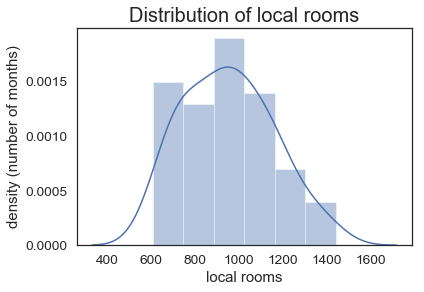

In [51]:
sns.distplot(df["local rooms"])#, bins=10)
plt.title("Distribution of local rooms", fontsize=20)
plt.xlabel("local rooms", fontsize=15)
plt.ylabel("density (number of months)", fontsize=15)
plt.show()


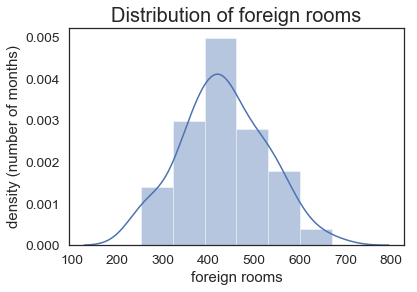

In [50]:
sns.distplot(df["foreign rooms"], bins=6)
plt.title("Distribution of foreign rooms", fontsize=20)
plt.xlabel("foreign rooms", fontsize=15)
plt.ylabel("density (number of months)",fontsize=15)
plt.show()

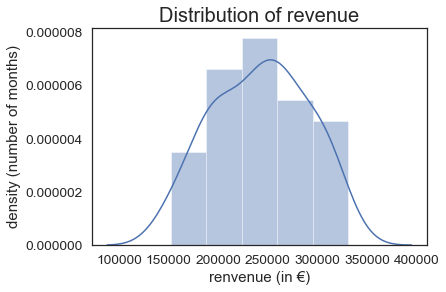

In [49]:
sns.distplot(df["revenue hotel"])#, bins=8)
plt.title("Distribution of revenue", fontsize=20)
plt.xlabel("renvenue (in €)", fontsize=15)
plt.ylabel("density (number of months)",fontsize=15)
plt.show()

### Correlation

Correlation of each used parameter for the analysis. It can be discovered a strong correlation between the occupation of local and foreign guests and rooms. Interesting about this is the correlation of all others to the hotel’s revenue which has a comparable low value. This indicates that there is less likely to be a correlation between the revenue and the occupation of the hotel.

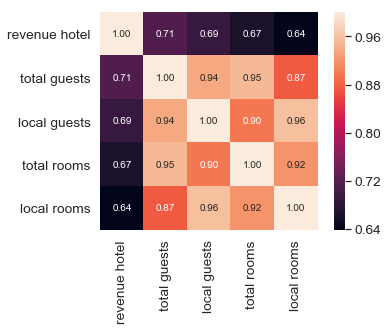

In [11]:
corrmat = df.corr()
k = 5
cols = corrmat.nlargest(k, 'revenue hotel')['revenue hotel'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### into report
# revenue is not that much likely dependent on number of guests or occupied rooms

### Regression models

By creating an OLS regression result for the revenue of the hotel and the occupation, one can see that the P value is for non of the parameters below 0.05 which indicates that the hypothesis of no correlation with the dependant parameter is more likely to be declined.
Further, the scatter plot below shows the regression models of all parameters of the OLS test which is elaborated in detail after that.

In [12]:
#rooms_l_const = sm.add_constant(df["local rooms"])
#model = sm.OLS(df["foreign rooms"], rooms_l_const).fit()
#print(model.summary())

y = df['revenue hotel']
x = df[['local guests', 'foreign guests', 'local rooms', 'foreign rooms']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          revenue hotel   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     18.09
Date:                Sat, 18 May 2019   Prob (F-statistic):           4.05e-10
Time:                        17:54:00   Log-Likelihood:                -850.40
No. Observations:                  72   AIC:                             1711.
Df Residuals:                      67   BIC:                             1722.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.723e+04    2.6e+04      1.

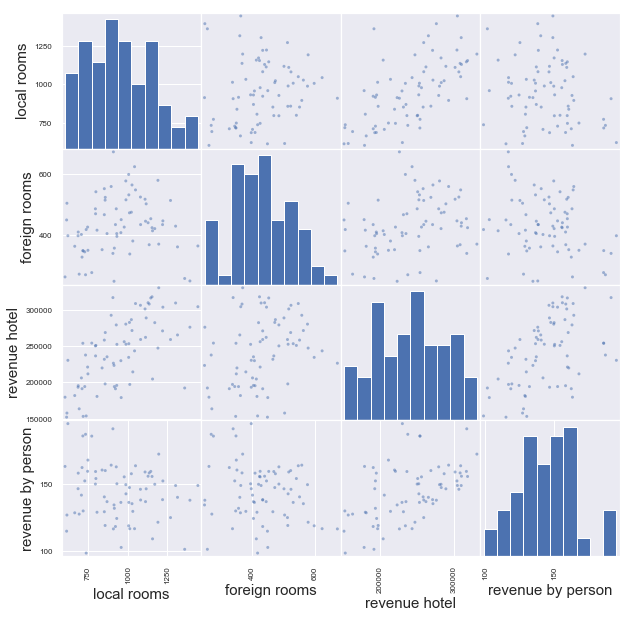

In [13]:
# create scatter plot only of selected data columns
pd.plotting.scatter_matrix(df[['local rooms', 'foreign rooms', 'revenue hotel', 'revenue by person']], figsize=(10, 10))
plt.show()

### Regression plots

For each of the following parameters a regression plot was created, also classifying the data by the year (yearly index) to show a difference over the period of time.

- local guests vs foreign guests
- total guests vs revenue hotel
- total guests vs revenue by person 
- total rooms vs revenue by room


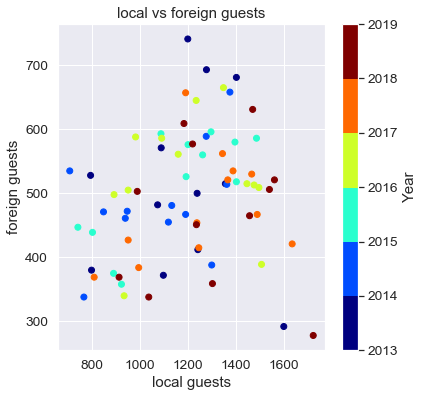

In [14]:
N = 7 # Number of labels
# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df['local guests']
y = df['foreign guests']
tag = df['year idx'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [2013,2014,2015,2016,2017,2018,2019]# np.linspace(2013,N,num=6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap,norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Year')
ax.set_title('local vs foreign guests')
ax.set_xlabel('local guests')
ax.set_ylabel('foreign guests')
plt.show()

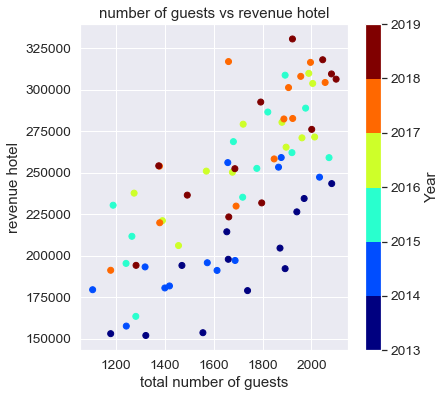

In [15]:
N = 7 # Number of labels
# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df['total guests']
y = df['revenue hotel']
tag = df['year idx'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [2013,2014,2015,2016,2017,2018,2019]# np.linspace(2013,N,num=6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap,norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Year')
ax.set_title('number of guests vs revenue hotel')
ax.set_xlabel('total number of guests')
ax.set_ylabel('revenue hotel')
plt.show()

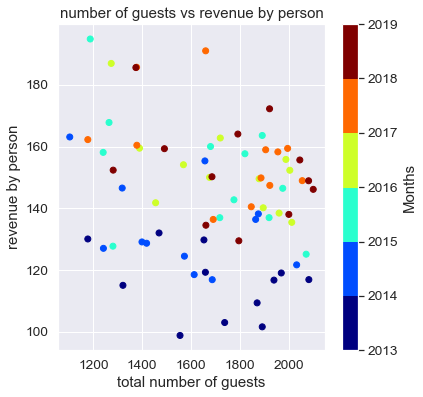

In [16]:
N = 7 # Number of labels
# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df['total guests']
y = df['revenue by person']
tag = df['year idx'] # Tag each point with a corresponding label    

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [2013,2014,2015,2016,2017,2018,2019]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap,norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Months')
ax.set_title('number of guests vs revenue by person')
ax.set_xlabel('total number of guests')
ax.set_ylabel('revenue by person')
plt.show()

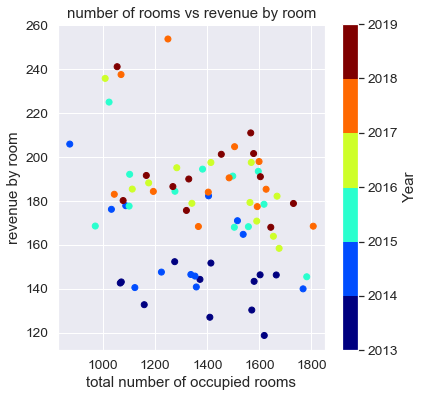

In [17]:
N = 7 # Number of labels
# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
# define the data
x = df['total rooms']
y = df['revenue by room']
tag = df['year idx'] # Tag each point with a corresponding label

# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [2013,2014,2015,2016,2017,2018,2019]# np.linspace(2013,N,num=6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(x,y,c=tag,cmap=cmap,norm=norm)
# create the colorbar
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
cb.set_label('Year')
ax.set_title('number of rooms vs revenue by room')
ax.set_xlabel('total number of occupied rooms')
ax.set_ylabel('revenue by room')
plt.show()

The regression plots above show the local guests related to the foreign guests, and the revenue related to the occupation by rooms. At first glance, there is not much special to discover.
It is discovered that the hotel's revenue is increased over the years with the same amount of guests; from 2013 to 2018 it is almost doubled. Even the revenue by room is increased for the same amount of occupied rooms. Further, the more rooms are occupied the less revenue by rooms can be discovered from the plots. This indicates that with less price for a room the occupation increases.
From the dependency of local and foreign guests is not much variance over the years to discover. In general, the more local guests occupy the hotel, the more foreign guests occupy the hotel, but this would not indicate that they are dependent on another. This is also visible in the correlation graph which results that the revenue of the hotel is less likely to be correlated to the occupation of the hotel.

For better demonstration of the regression, a line is added to the regression plots classified by each year. With this the interpretation above is proved easier.

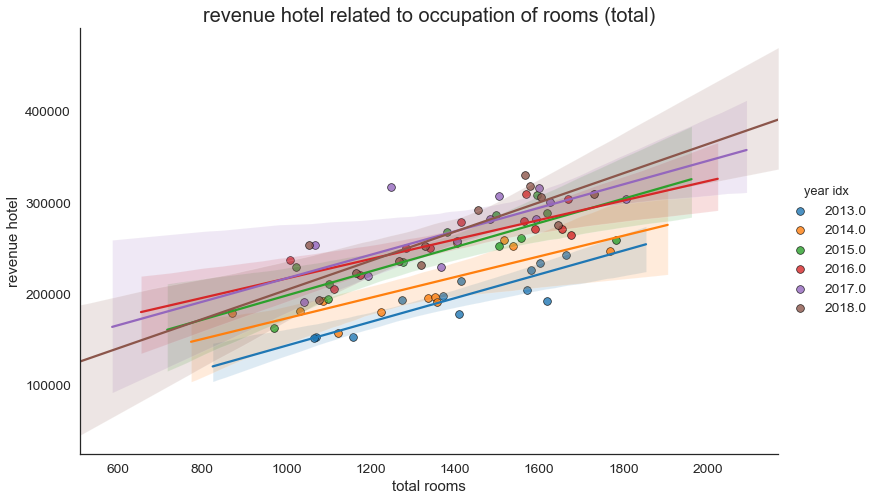

In [18]:
#local guests vs foreign guests
#total guests vs revenue hotel
#total guests vs revenue by person 
#total rooms vs revenue by room

# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="total rooms", y="revenue hotel", hue="year idx",
                     data=df,
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
#gridobj.set(xlim=(0.5, 7.5), ylim=(0, 50))
plt.title("revenue hotel related to occupation of rooms (total)", fontsize=20)
plt.show()

C:\Users\Torben\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:278: RuntimeWarning: divide by zero encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
C:\Users\Torben\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:278: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
C:\Users\Torben\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
C:\Users\Torben\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Torben\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1876: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff
C:\Users\Torben\Anaconda3\lib\site-packages\numpy\lib\function_base.py:

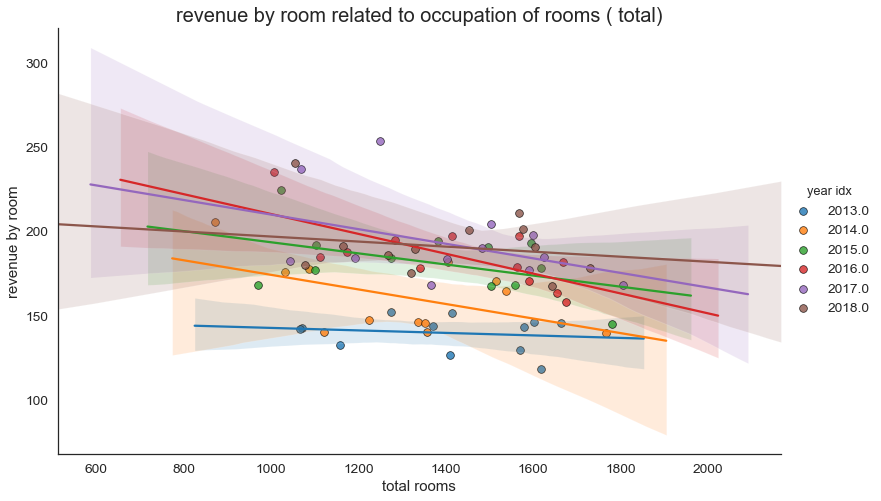

In [19]:
# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="total rooms", y="revenue by room", hue="year idx",
                     data=df,
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
#gridobj.set(xlim=(0.5, 7.5), ylim=(0, 50))
plt.title("revenue by room related to occupation of rooms ( total)", fontsize=20)
plt.show()

## Time series

By comparing the the amount of local and foreign guests one can see difference in monthly occupation and a very large deviation of occupation throughout the years. There is no strong increase or decrease over the years visible, neither for local nor for foreign guests. The foreign guests are not a large part of the total amount of guests, visible in the graph with summed guests.

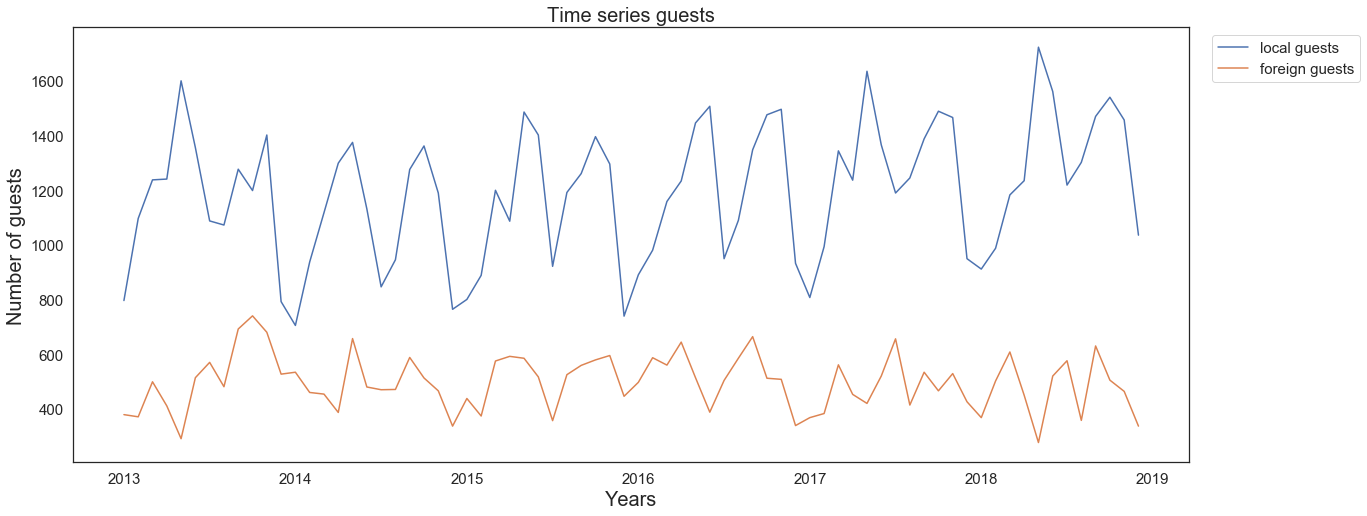

In [20]:
df[['local guests', 'foreign guests']].plot(figsize=(20, 8), fontsize=15)
plt.title('Time series guests', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of guests', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor=(1.16, 1.0))
plt.show()

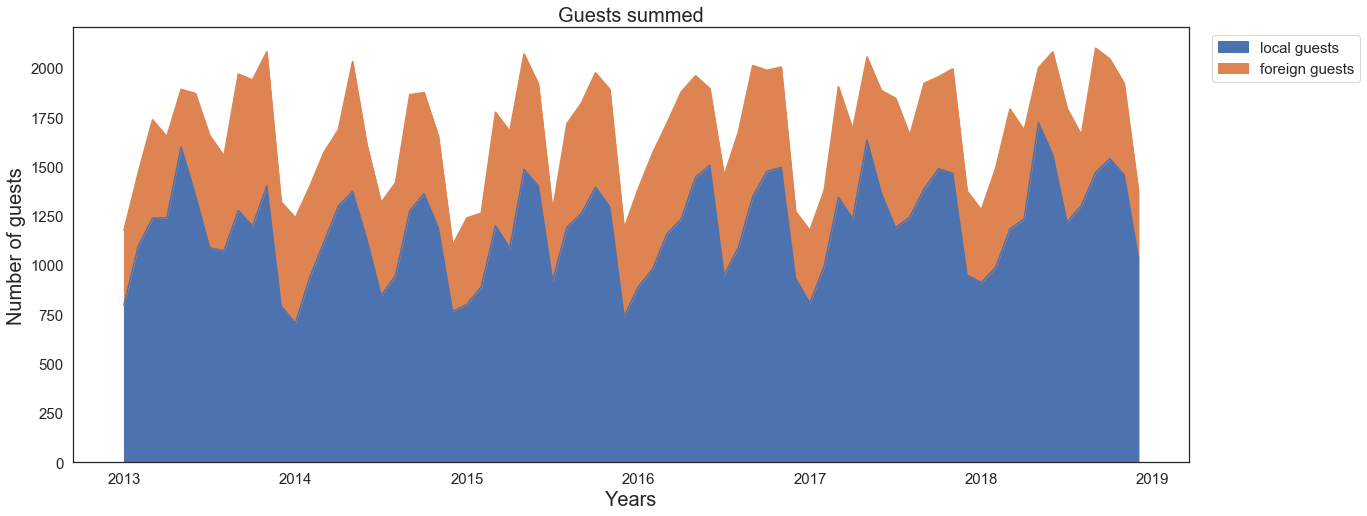

In [21]:
df[['local guests', 'foreign guests']].plot.area(figsize=(20, 8), fontsize=15)
plt.title('Guests summed', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of guests', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor=(1.16, 1.0))
plt.show()

### Time series total rooms occupation (local vs foreign)

Comparing the plot of the amount of guests and the occupation by rooms, it gets clear that they are strong correlated as well as the correlation plot showed. In the following time series analysis, the occupation by rooms only will be taken into account.

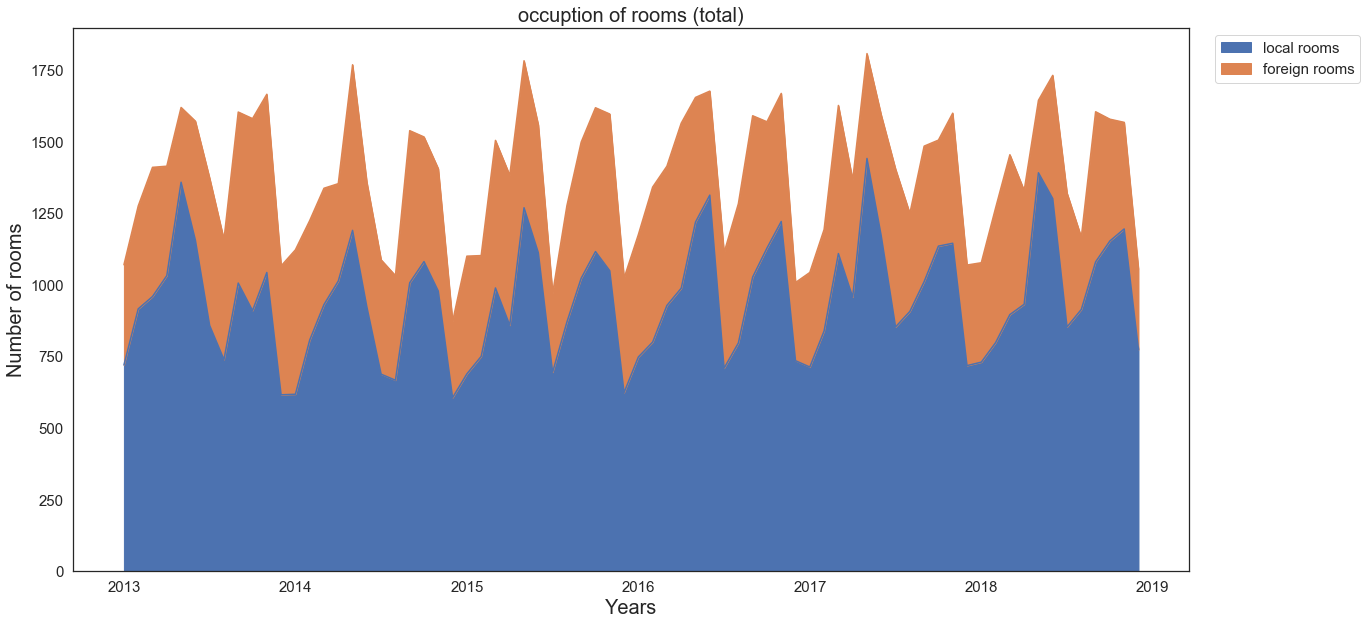

In [22]:
df[['local rooms', 'foreign rooms']].plot.area(figsize=(20,10), fontsize=15)
plt.title('occuption of rooms (total)', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.ylabel('Number of rooms', fontsize=20)
plt.legend(fontsize=15, bbox_to_anchor=(1.16, 1.0))
plt.show()

## Time series analysis of rooms occupation

#### Time series correlation

Inspecting the autocorrelation and the partial autocorrelation of the local and foreign rooms, as well as total rooms and revenue of the hotel, a strong periodicity is not visible. Even though there are signs of periodicity in the auto correlation plots there are no clear patterns in the correlation plots visible. Do take a deeper look, the time series will be seasonal decomposed to inspect and separate the trend and seasonality from the observed data.

C:\Users\Torben\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


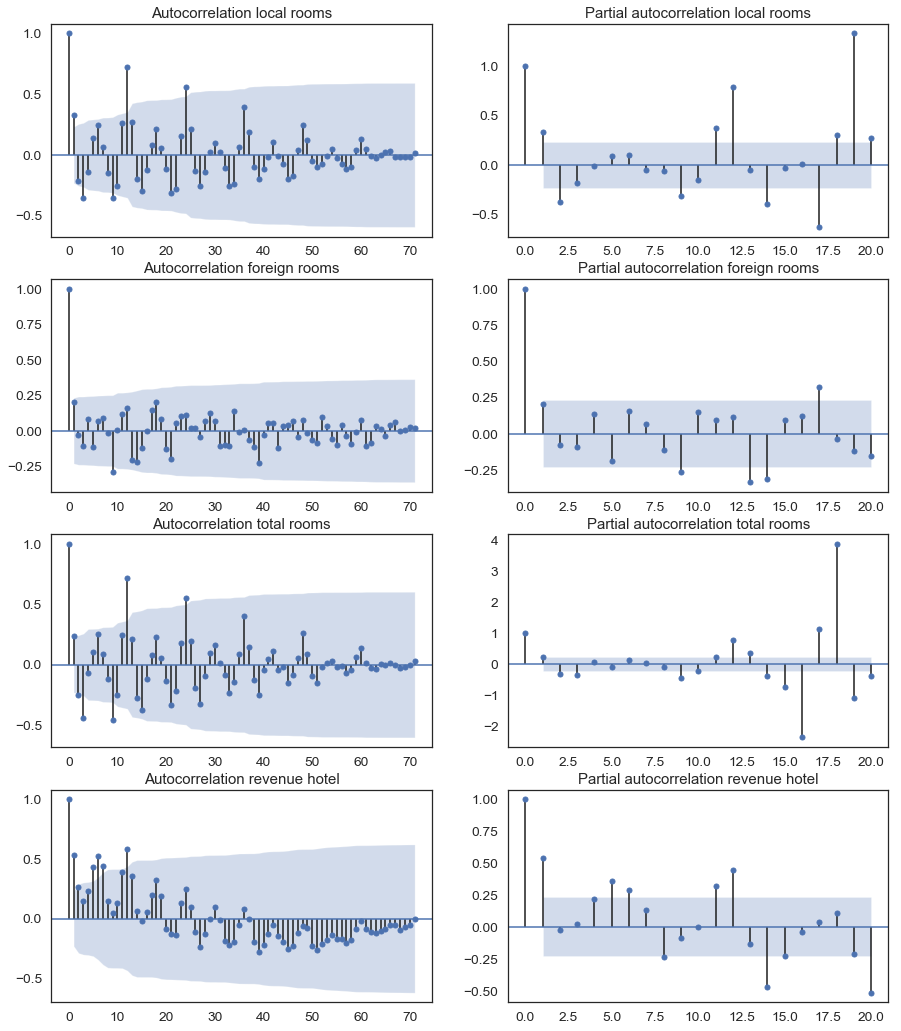

In [23]:
fig = plt.figure(figsize = (15,18))
grid_size = (4,2)
hosts_to_fmt = []
# 1
tier_axis = plt.subplot2grid(grid_size, (0,0))
ax1 = tsaplots.plot_acf(df['local rooms'], ax=tier_axis, title='Autocorrelation local rooms')
hosts_to_fmt.extend([ax1])
tier_axis = plt.subplot2grid(grid_size, (0,1))
ax1 = tsaplots.plot_pacf(df['local rooms'], ax=tier_axis, title='Partial autocorrelation local rooms', lags=20)
hosts_to_fmt.extend([ax1])

# 2
tier_axis = plt.subplot2grid(grid_size, (1,0))
ax1 = tsaplots.plot_acf(df['foreign rooms'], ax=tier_axis, title='Autocorrelation foreign rooms')
hosts_to_fmt.extend([ax1])
tier_axis = plt.subplot2grid(grid_size, (1,1))
ax1 = tsaplots.plot_pacf(df['foreign rooms'], ax=tier_axis, title='Partial autocorrelation foreign rooms', lags=20)
hosts_to_fmt.extend([ax1])

# 3
tier_axis = plt.subplot2grid(grid_size, (2,0))
ax1 = tsaplots.plot_acf(df['total rooms'], ax=tier_axis, title='Autocorrelation total rooms')
hosts_to_fmt.extend([ax1])
tier_axis = plt.subplot2grid(grid_size, (2,1))
ax1 = tsaplots.plot_pacf(df['total rooms'], ax=tier_axis, title='Partial autocorrelation total rooms', lags=20)
hosts_to_fmt.extend([ax1])

# 4
tier_axis = plt.subplot2grid(grid_size, (3,0))
ax1 = tsaplots.plot_acf(df['revenue hotel'], ax=tier_axis, title='Autocorrelation revenue hotel')
hosts_to_fmt.extend([ax1])
tier_axis = plt.subplot2grid(grid_size, (3,1))
ax1 = tsaplots.plot_pacf(df['revenue hotel'], ax=tier_axis, title='Partial autocorrelation revenue hotel', lags=20)
hosts_to_fmt.extend([ax1])

#### Decomposition

With the seasonal decomposition the seasonality and trend are separated from the observed data as well as the residuals. In each of the time series a similar pattern of seasonality can be extracted as well as a clearly visible trend which is neither increasing nor decreasing for the occupation, by inspecting the y axis and the deviation range. For the revenue of the hotel of the trend deviates from more than 125% from the first measured value (200000 to 250000) which indicates a high increase over time.

##### Seasonal decomposition - local rooms

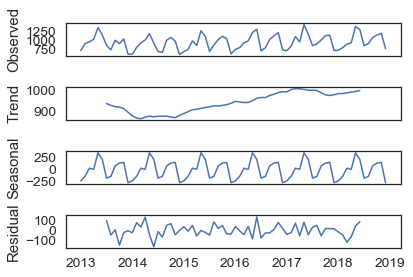

In [24]:
df_SD_local = seasonal_decompose(df["local rooms"], model='additive', freq=12)
df_SD_foreign = seasonal_decompose(df["foreign rooms"], model='additive', freq=12)
df_SD_total = seasonal_decompose(df["total rooms"], model='additive', freq=12)
df_SD_revenue = seasonal_decompose(df["revenue hotel"], model='additive', freq=12)

df_SD_local.plot()
plt.show()

##### Seasonal decomposition - foreign rooms

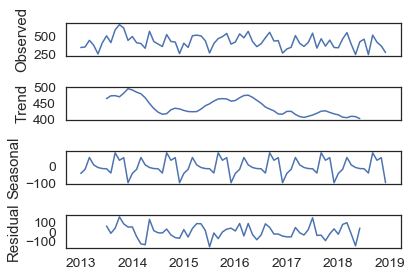

In [25]:
df_SD_foreign.plot()
plt.show()

##### Seasonal decomposition - total rooms

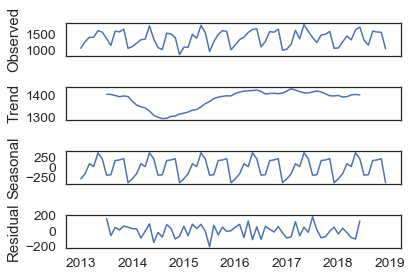

In [26]:
df_SD_total.plot()
plt.show()

##### Seasonal decomposition - revenue hotel

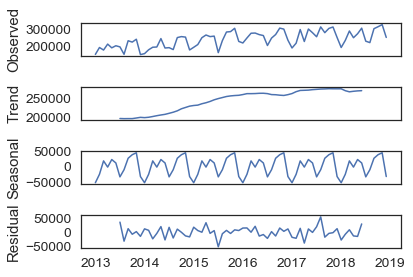

In [27]:
df_SD_revenue.plot()
plt.show()

#### Seasonality comparison

The following plot shows the total, local and foreign occupation of rooms. The seasonality of the occupation differs not much between all of these time series. They cover the same peaks (increase and decrease), though a strange peak for local rooms occupation is visible which is not there for foreign rooms.

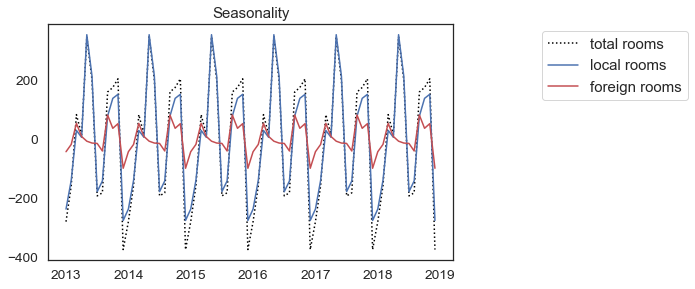

In [28]:
fig = plt.figure(figsize = (16,20))
tier_axis = plt.subplot2grid(grid_size, (0,0))
df_SD_total.seasonal.plot(ax=tier_axis, label='total rooms', linestyle='dotted', color='black', legend=True)
df_SD_local.seasonal.plot(ax=tier_axis, label='local rooms',title='Seasonality', legend=True, color='b')
df_SD_foreign.seasonal.plot(ax=tier_axis, label='foreign rooms', legend=True, color='r')
tier_axis.legend(fontsize=15, bbox_to_anchor=(1.2, 1.0))
plt.show()

## Time series comparison (local vs foreign rooms with trends)

Inspecting the observed data with the trend of each of the timeseries (local, foreign, total rooms and revenue) the observations stated before can be approved. The trend of the revenue is the only that differs much over the years with a high increase over time. Even though it is not easy to dicover is a slight decrease of foreign occupation of the rooms but a slight increase of the local occupation comparing the years 2013 and 2018. The total occupation itself remains at a same level.

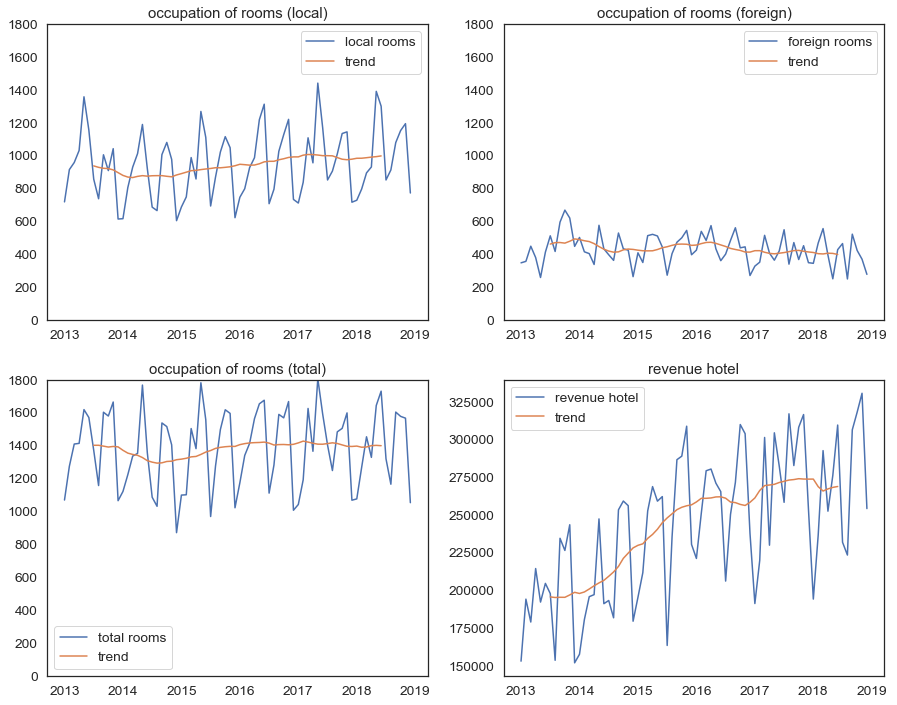

In [29]:
# comparison of local, foreign and total occupation of rooms and revenue hotel in subplots

fig = plt.figure(figsize = (15,12))
grid_size = (2,2)
hosts_to_fmt = []
# 1
tier_axis = plt.subplot2grid(grid_size, (0,0))
df['local rooms'].plot(title="occupation of rooms (local)", label='local rooms')
ax1 = df_SD_local.trend.plot(ax=tier_axis, label='trend')
ax1.set_ylim(0,1800)
ax1.legend()
hosts_to_fmt.extend([ax1])
# 2
tier_axis = plt.subplot2grid(grid_size, (0,1))
df['foreign rooms'].plot(title="occupation of rooms (foreign)", label='foreign rooms')
ax1 = df_SD_foreign.trend.plot(ax=tier_axis, label='trend')
ax1.set_ylim(0,1800)
ax1.legend()
hosts_to_fmt.extend([ax1])
# 3
tier_axis = plt.subplot2grid(grid_size, (1,0))
df['total rooms'].plot(title="occupation of rooms (total)", label='total rooms')
ax1 = df_SD_total.trend.plot(ax=tier_axis, label='trend')
ax1.set_ylim(0,1800)
ax1.legend()
hosts_to_fmt.extend([ax1])
# 4
tier_axis = plt.subplot2grid(grid_size, (1,1))
df['revenue hotel'].plot(title="revenue hotel", label='revenue hotel')
ax1 = df_SD_revenue.trend.plot(ax=tier_axis, label='trend')
ax1.legend()
hosts_to_fmt.extend([ax1])
plt.show()

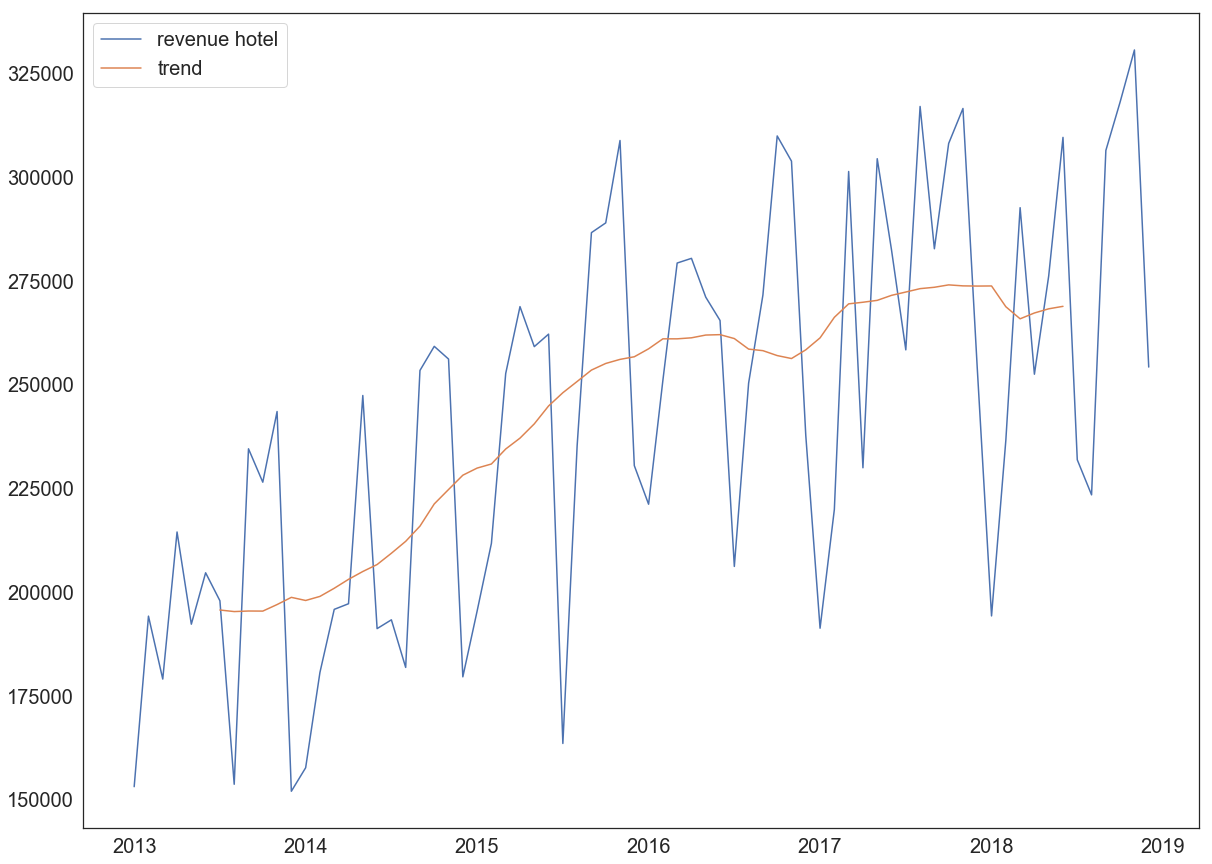

In [30]:
df['revenue hotel'].plot(label='revenue hotel', fontsize=20, figsize=(20,15))
df_SD_revenue.trend.plot(label='trend', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Results and discussion

Let us remind our initial hypotheses: 1 - The hotel is more occupied by local than foreign guests; 2 - Seasonality has a small impact on the occupation due to the business tourism and several cultural events throughout the year close to the area were the hotel is situated; 3 - The revenue of the hotel depends on the occupation of the hotel. An increase of occupation will show an increase of the revenue.
The results obtained by analysis of the data indicates that hypothesis 1 and 2 proved to be right.
The distribution plots visualize how the occupation of the rooms in the hotel is counted throughout the time period. The data is nearly normal distributed following a similar pattern of a normal distribution where the normal curve is bell shaped and symmetric about the mean. The range of the local rooms occupation is much more with 600 to 1400 than the foreign rooms occupation with 250 to 700. This underlines as well the statistical description of the data, where the local occupation of guests are around 70% of the total guests (Figure 1 & 2). The revenue of the hotel of the last six years has its mean at ~242.300€ with a very high range and also a standard deviation lying at 15% of the mean (~50.000€). Figure 3 shows the correlation between each parameter of the dataset. It is clearly visible that there is a very strong correlation between the occupation of the guests and rooms. There is even a higher correlation between the local occupation (local guests and rooms) and the total occupation (total guests and rooms) which is also related to the fact, that circa 70% of the total occupation is the local occupation. Now, it would be expected, that the revenue of the hotel is somehow dependent on the occupation of the hotel. There is as well correlation, but interesting to see here is that there is less correlation between the revenue of the hotel and the occupation of the hotel with a value of around 0.7 (Figure 3).

As the distribution and the time series of the guest occupation is following nearly the same pattern as the rooms occupation, the rooms occupation will be used for further analysis in this report. The analysis and plots of the guest occupation are visualized in the python script only.
Comparing the amount of local and foreign rooms one can see difference in volume and monthly occupation. Further, there is a large deviation of occupation throughout the years. There are a lot low peaks in the beginning and the middle of the year and high peaks following each low peak. In general there is no large increase or decrease visible from the separation of local and foreign guests (Figure 4). Similarities between the distribution of rooms occupation over the years show that the hotel was able to maintain a stabilized performance concerning the lodging business throughout the last six years. Highlighted through the correlation and distribution plots, it can be seen that the foreign occupation follow a similar pattern as the local occupation and are just a small part of the whole occupation, around 20% throughout the year.
Having a closer look on the relation of the occupation and the revenue, regression plots are used to combine rooms occupation and revenue in total and rooms occupation and revenue by room. These regression plots show each month as a dot containing the value of the total rooms occupation and the revenue of the hotel for this month. The dots are classified by the years and colored in the same color for each year to compare the yearly development. Further, a regression line created with the method of least squares shows the mean of each year and the trend of the relation of both parameters (Figure 5 and 6).
Concerning revenue from occupied rooms, overall there is an increase over the years, especially noted from year 2014 (orange) to 2015 (green). The pattern of relation between the two parameters is very similar in each year. This plot expresses as well that with a high occupancy of rooms the revenue is high too. Though, there are some "outliers" showing that even with the same amount of occupied rooms the revenue is the same for a month (Figure 5). However, there is not a significant increase of revenue with the increase of occupied rooms, which shows that the dependence of one parameter from another is not strongly decisive on the overall revenue.
Figure 6 shows the relation of the occupation and the revenue by room. Here at first glance a similar pattern of the yearly comparison is visible. Over the past six years the revenue by room has been increased. Further, the regression lines are different from Figure 5. It shows an optical decrease which means that the lower the revenue by room, the more rooms were occupied. This could indicate a decrease of the price of the rooms, which results in an increase of guests, because the price is lower than usual (Figure 6).
Comparing both plots it gets clear that if the revenue by room increases also the total revenue increases and vice versa. Moreover, the increase of the revenue over the year is an important fact as well as that there might be more occupation concerning less price for a room, because the revenue by room decreases with more occupation.
Figure 7 shows the time series for each of the analysed parameters (occupation of rooms: local, foreign, total; revenue hotel) with the trend of each. At first glance comparing the occupation and the revenue the trend has a completely different shape. Though, there are a lot high and low peaks throughout each year and over the period of time, the trend of the occupation remains nearly constant with slight increase in the local occupation and slight decrease in the foreign occupation. But the revenue of the hotel increases to a doubled value over the last six years. This supports the assumption that the revenue of the hotel is not significantly dependent on the occupation, but more on the pricing of the rooms and other factors, which are not analysed in this report.


## Conclusion

The insights that were able to achieve from the initial dataset by using data science techniques provide a clear view of the hotel’s business and performance over the last six years related to the occupation of the hotel in combination with the revenue. As discovered from the analysis there are similarities between the distribution of rooms occupancy (local and foreign) over the years, showing that the hotel has been able to maintain a stabilized performance concerning the lodging business, though, the occupation of local guests slightly increased while the occupation of foreign guests slightly decreased. This might help the hotel management in trying to find ways to also attract more foreign guests again, so that this stabilized performance remains in future years. In general, the time series analysis of occupied rooms (local and foreign), and revenue shows consistency on the behavior over the years. The revenue tends to increase, with less accentuated losses at the end of the period. Furthermore, based on the regression plots (Figure 5 and 6) the analysis concluded that the pricing of rooms changes in between years and increases over time which affects the revenue of the hotel more than the occupation which remains nearly stable. Deducing, there might be a way in further improve the calculation of the room pricing to increase either the revenue as well as the occupation of the hotel throughout the year. Additionally, the low peaks during a year could be solved somehow.

## Acknowledgements

We would like to thank the hotel who helped us in this project. We are very grateful for the collaboration and trust they demonstrated by giving us access to their internal data with the permission to analyse it and do assumptions upon their data for the last six years. 

## References

1. Data Science from Scratch - Joel Grus (O’Reilly)
2. Python for Data Analysis - Wes McKinney (O’Reilly)
3. Python Data Science Handbook - Jake VanderPlas (O’Reilly)
4. Data Science for Business - Foster Provost & Tom Fawcett (O’Reilly)